In [1]:
#Circle bundle imports
import circle_bundles as cb
from circle_bundles.metrics import RP1AngleMetric as rp1_metric

#For visualizations
cb.attach_bundle_viz_methods()


#For persistent homology computations
from ripser import ripser
from persim import plot_diagrams

#For generating synthetic natural image patch samples and computing gradient directions
from synthetic.nat_img_patches import sample_nat_img_kb, get_gradient_dirs

#For visualizing natural image patches
import matplotlib.pyplot as plt
from optical_flow.patch_viz import make_patch_visualizer



# Generate A Synthetic Sample

In [2]:
#Generate a sampling of the Klein bottle model over RP1

n_patches = 5000  #CHOOSE A SAMPLE SIZE
n = 3   #CHOOSE A PATCH SIZE

data = sample_nat_img_kb(n_patches, n = n)[0]
grad_dirs = get_gradient_dirs(data)[0]   #Compute predominant gradient directions

#Create a visualizer function
patch_vis = make_patch_visualizer()

print(f'{n_patches} natural image patches generated.')

5000 natural image patches generated.


## Preliminary Analysis 

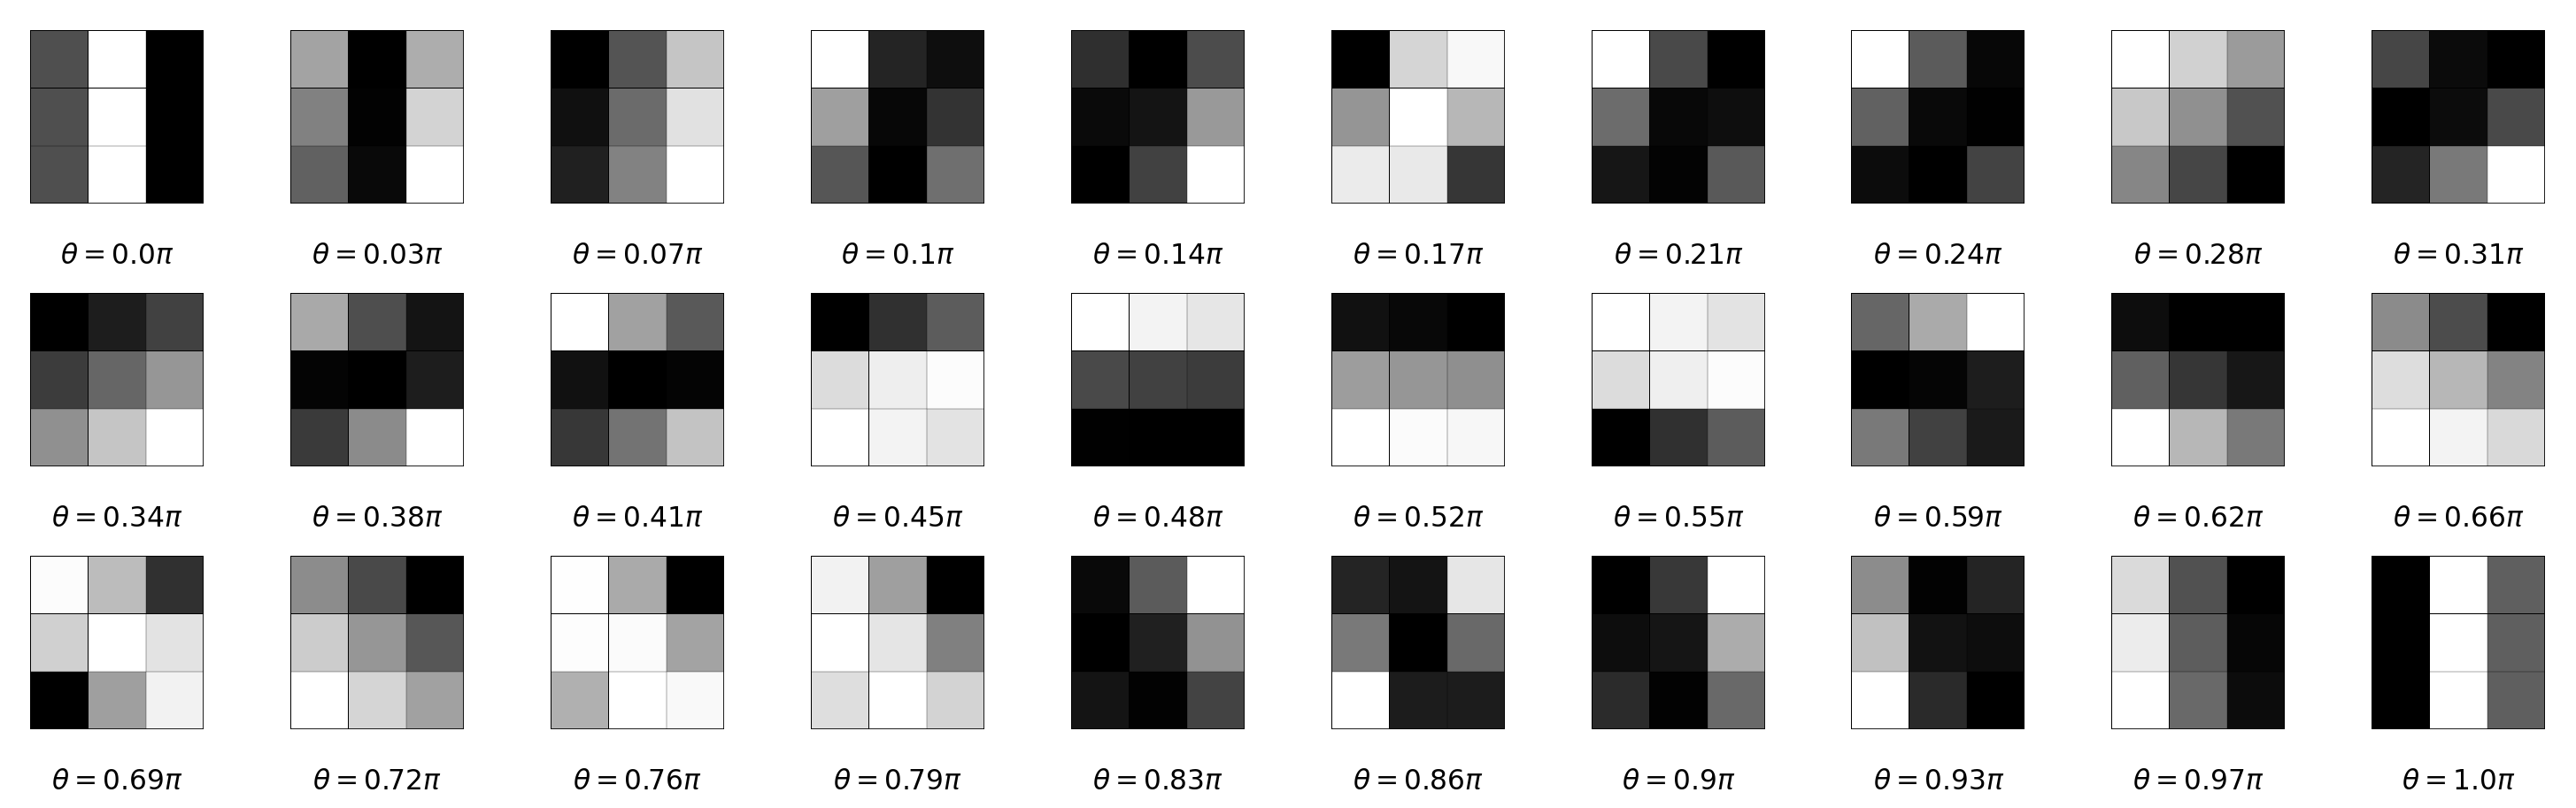

In [3]:
#View a random sample of the dataset arranged by gradient direction
n_samples = 30

label_func = [fr"$\theta = {np.round(grad/np.pi, 2)}$" + r"$\pi$" for grad in grad_dirs]
fig = cb.show_data_vis(data, 
                       patch_vis, 
                       label_func = label_func, 
                       angles = grad_dirs, 
                       sampling_method = 'angle', 
                       max_samples = n_samples)
plt.show()


In [ ]:
#Show an interactive visualization of the projection map
app = cb.show_bundle_vis(base_points = grad_dirs.reshape(-1,1), 
                         data  = data, 
                         base_metric = cb.RP1AngleMetric(), 
                         colors = grad_dirs)   #Colored according to base projection

In [ ]:
#Run Ripser on a sample of the full dataset

#Compare persistent homology over two different coefficient fields
dgms_2 = ripser(data, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(data, coeff=3, maxdim=2, n_perm=500)["dgms"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title="coeff = 2")
plot_diagrams(dgms_3, ax=axes[1], title="coeff = 3")

plt.tight_layout()
plt.show()


## Bundle Analysis 

### Cover And Nerve Summary
- $n_\text{sets} = 12$, $n_\text{samples} = 5000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 12$
- $\#(\text{1-simplices}) = 12$
- *No recorded simplices in dimensions* $\ge 2$

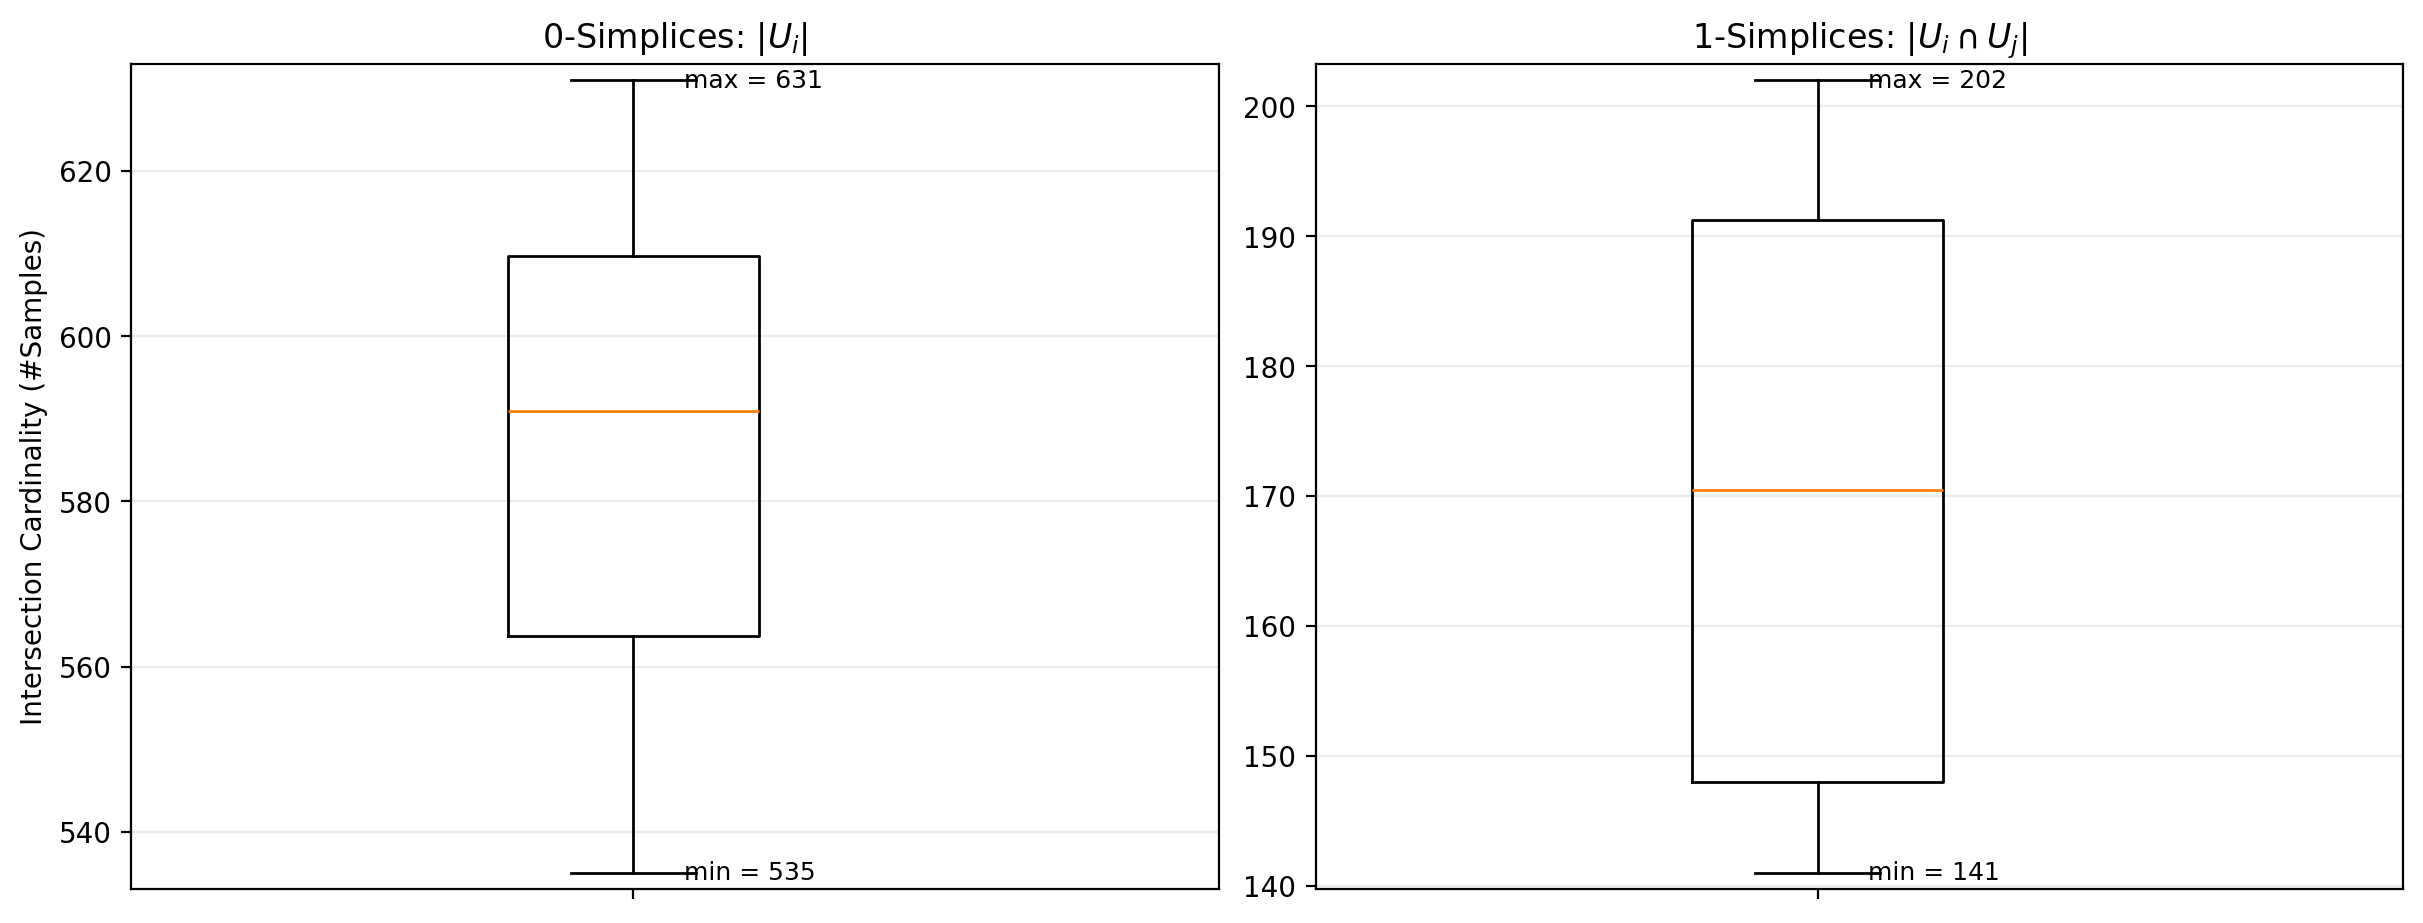

In [4]:
#Construct a cover of the base space

n_landmarks = 12
landmarks = np.linspace(0, np.pi,n_landmarks, endpoint= False)
overlap = 1.4

radius = overlap* np.pi/(2*n_landmarks)

cover = cb.MetricBallCover(grad_dirs, landmarks, radius, metric = rp1_metric())
cover_data = cover.build()

#Show a summary of the cover
summ = cover.summarize(plot=True)
plt.show()

In [5]:
#Construct local circular coordinates using Dreimac library
#and model transitions as O(2) matrices

from dreimac import CircularCoords  #OPTION: import Dreimac for local circular coordinates

bundle = cb.build_bundle(
    data,
    cover,
#    CircularCoords_cls=CircularCoords,     #OPTION: use Dreimac for circular coordinates
    show=True,
)


<IPython.core.display.Math object>

In [ ]:
#Show the correlations between local circular coordinates on overlaps
fig = bundle.compare_trivs(ncols = 4)
plt.show()

In [ ]:
#Compute class persistence on the weights filtration of the nerve
pers = bundle.get_persistence(show = True)


In [6]:
#Construct a classifying map to the Stiefel manifold and compute the pullback bundle
pullback_results = bundle.get_pullback_data(
    base_weight=1.0,
    fiber_weight=1.0,
    packing = 'coloring2'
)


<IPython.core.display.Math object>

In [7]:
pb_bundle = cb.build_bundle(
    pullback_results.total_data,
    cover,
#    CircularCoords_cls=CircularCoords,     #OPTION: use Dreimac for circular coordinates
    show=True,
    total_metric = pullback_results.metric 
)


<IPython.core.display.Math object>

In [8]:
#Show an interactive visualization of the pullback bundle
app = pb_bundle.show_bundle()

Bundle viewer running at: http://127.0.0.1:51293/


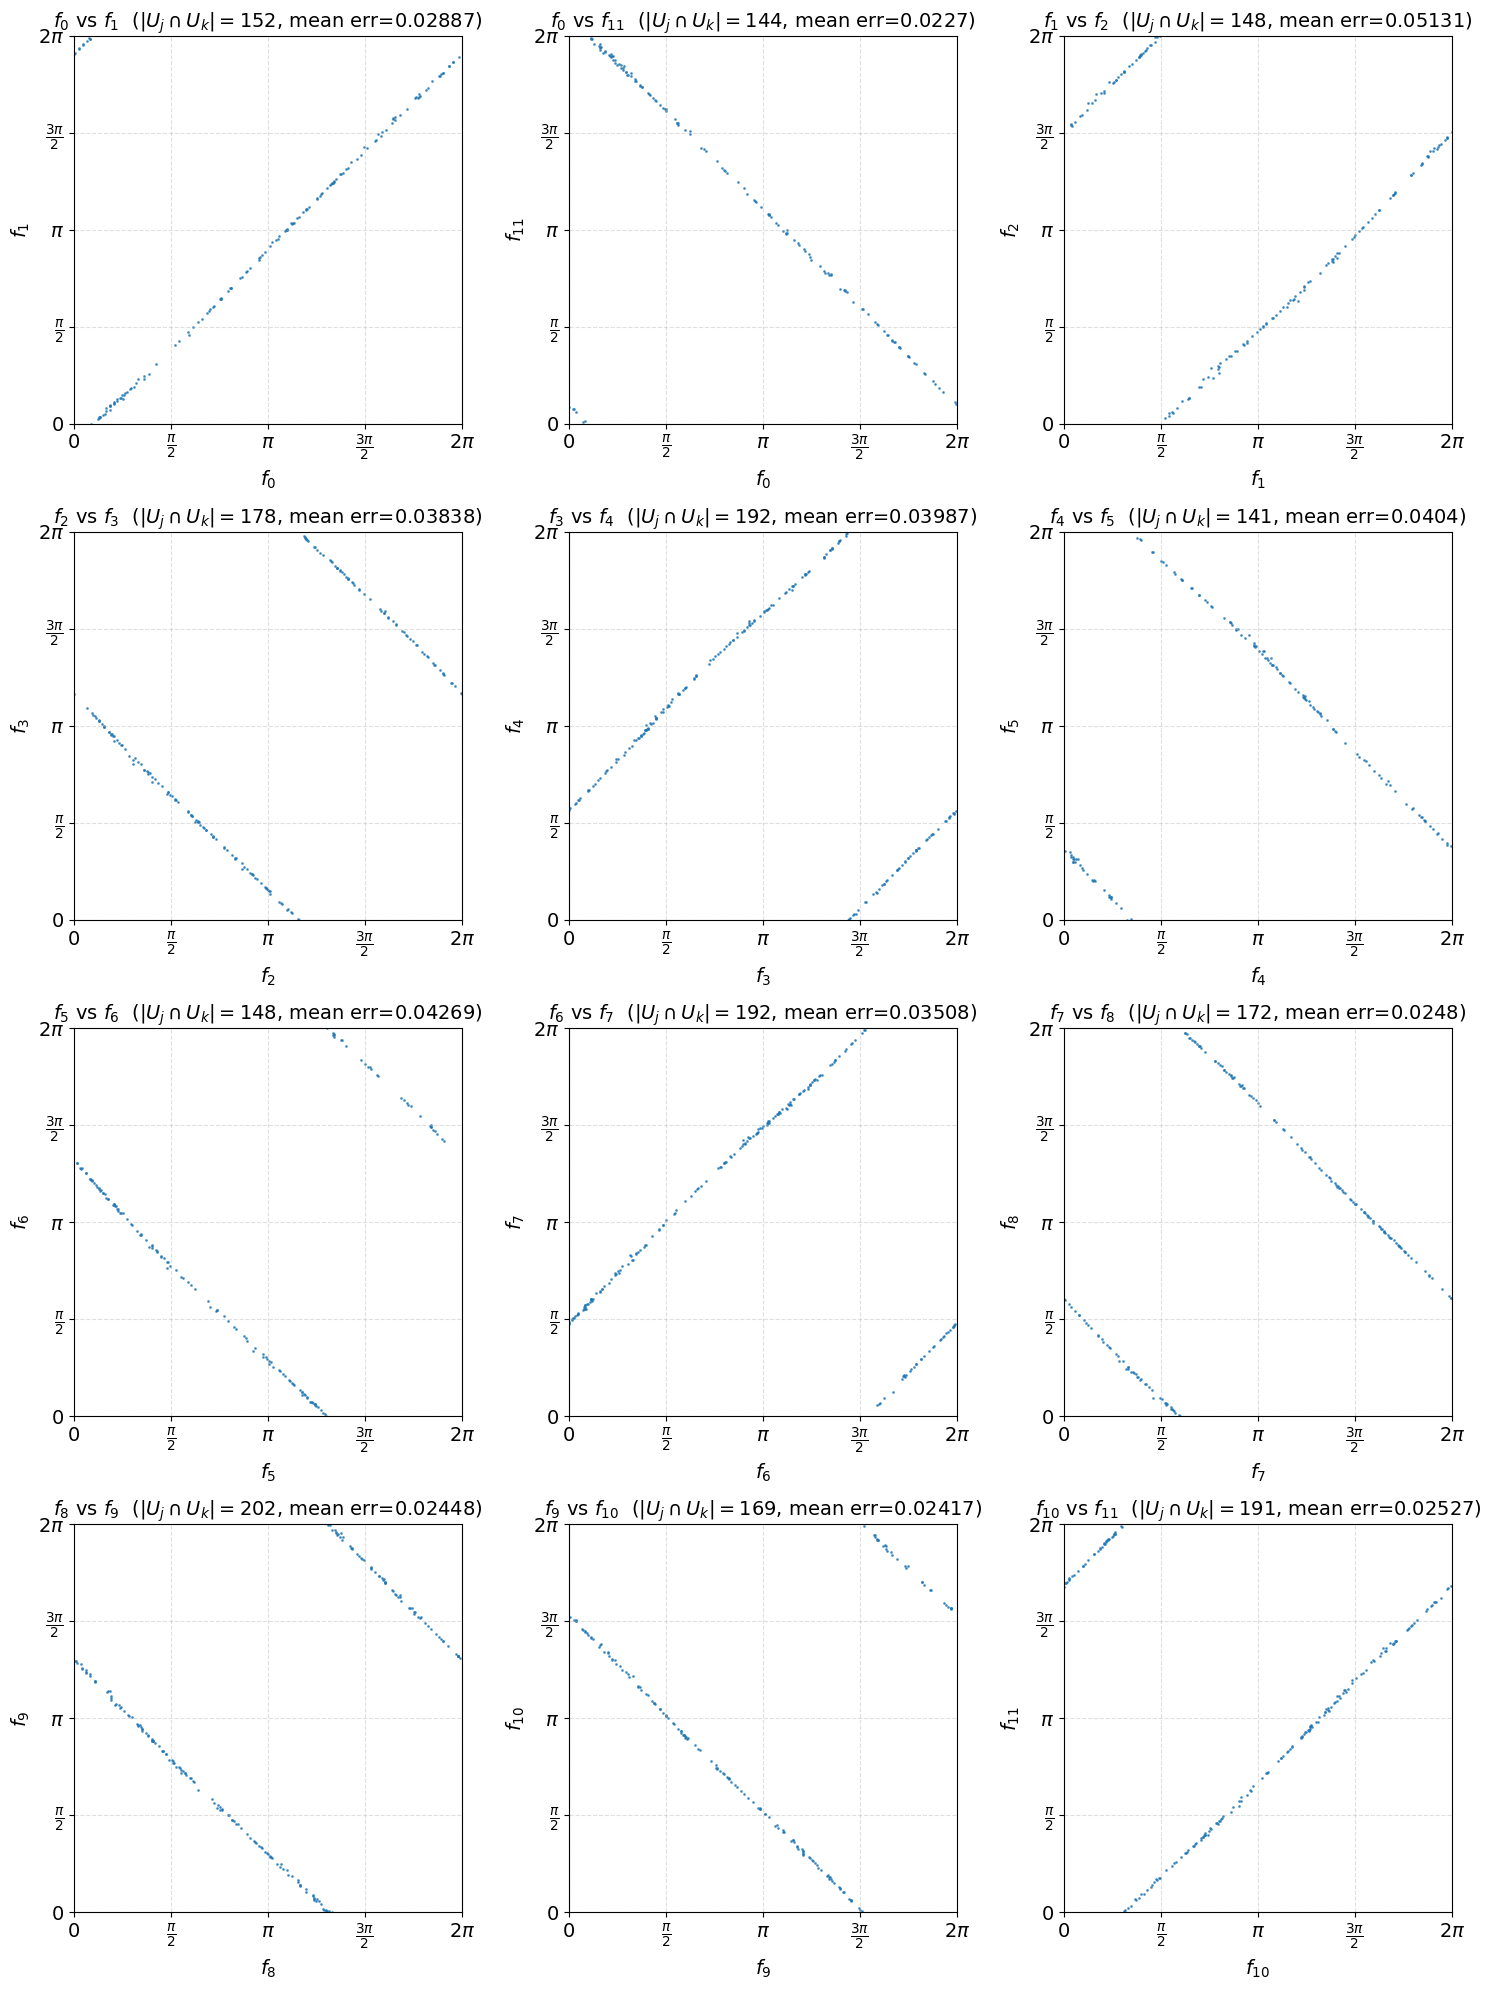

In [9]:
fig = pb_bundle.compare_trivs()
plt.show()

In [ ]:
# Run Ripser on the total space of the pullback bundle
n_subsamples = 500
samples = pb_bundle.data[:n_subsamples]
dist_mat = pb_bundle.total_metric.pairwise(samples)

dgms_2 = ripser(dist_mat, distance_matrix = True, coeff=2, maxdim=2)["dgms"]
dgms_3 = ripser(dist_mat, distance_matrix = True, coeff=3, maxdim=2)["dgms"]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title="coeff = 2")
plot_diagrams(dgms_3, ax=axes[1], title="coeff = 3")

plt.tight_layout()
plt.show()


In [ ]:
#Get a global coordinatization compatible with the maximal subcomplex of the nerve on which 
#the characteristic class representatives are coboundaries 

triv_result = bundle.get_global_trivialization()
print('Global coordinates computed.')

In [ ]:
#Show an interactive visualization of the bundle colored by fiber coordinate
fig = bundle.show_bundle(colors = triv_result.F)
plt.show()



In [ ]:
#Show a visualization of the nerve labeled with SW1

#Compute a potential for the restricted orientation class
subcomplex = bundle.get_max_trivial_subcomplex()
edges = subcomplex.kept_edges
Omega = bundle.classes.cocycle_used.restrict(edges)
phi_vec = Omega.orient_if_possible(edges)[2]
phi = {lmk: phi_vec[lmk] for lmk in range(n_landmarks)}
omega = bundle.classes.omega_O1_used

fig = bundle.show_circle_nerve(omega = omega, phi = phi)
plt.show()

In [ ]:
#Show a recovered patch diagram
per_row = 5
per_col = 9
coords = np.column_stack([grad_dirs.reshape(-1,1), triv_result.F.reshape(-1,1)])

fig = cb.lattice_vis(
    data,
    coords,
    patch_vis,
    per_row=per_row,
    per_col = per_col,
    figsize=19,
    thumb_px=350,   
    dpi=350         
)

plt.show()
